# Урок 5. Случайный лес

**План занятия**

* [Теоретическая часть](#theory)
    * [Разложения ошибки на смещение и разброс](#bias_variance)
    * [Алгоритм построения случайного леса](#alg)
        * [Out-of-Bag](#oob)
    * [Реализация случайного леса](#implement)
* [Домашнее задание](#hw)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

Данный урок будет своеобразным логическим продолжением предыдущего. Основным недостатком деревьев решений является их склонность к переобучению и тот факт, что даже при небольшом изменении обучающей выборки дерево может значительно измениться. Однако их объединение в _ансамбли_ или _композиции_ на практике дает очень хорошие результаты. Ансамбли - это методы, сочетающие в себе несколько алгоритмов машинного обучения для получения более мощной модели. 

В случае задачи регрессии при использовании композиции $a(x)$ из $N$ _базовых алгоритмов_ $b_{n}(x)$ ответом будет считаться среднее значение ответа каждого алгоритма

$$a(x) = \frac{1}{N}\sum_{n=1}^{N}b_{n}(x),$$

в задачах классификации, соответственно, знак полученного усредненного ответа или (что аналогично) класс определяется путем *голосования*: объект относится к классу, за который "проголосовало" наибольшее число базовых алгоритмов.

Одни из самых хорошо зарекомендовавших себя на практике решения задач классификации и регрессии с использованием деревьев решения - это _случайные леса_ и _градиентный бустинг_. В этом уроке пойдет речь о первом методе.

<img src='images/rf_explained.png'>

## Разложения ошибки на смещение и разброс<a class='anchor' id='bias_variance'>

Известно, что ошибка алгоритмов складывается из _смещения (bias)_ (отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма) и _разброса_ или _дисперсии (variance)_ (разброс ответов обученных алгоритмов отнисительно среднего ответа). Также к этому разложению обычно прибавляется *шум*, который характеризует ошибку идеального алгоритма и которым никак нельзя управлять - это характеристика входных данных. Как правило, простые семейства алгоритмов (например, линейные классификаторы) характеризуются высоким смещением и низким разбросом, а сложные семейства (в т.ч. деревья) наоборот - низким смещением и высоким разбросом. Можно сказать, что разброс характеризует чувствительность метода обучения к выборке, то есть насколько будет изменяться ответ обученного алгоритма в зависимости от изменений в обучающей выборке.

<center>Ошибка на новых данных = Шум + Смещение + Разброс, где</center>

ШУМ - ошибка лучшей модели a(x)

СМЕЩЕНИЕ - отклонение усредненных ответов наших моделей от ответов лучшей модели a(x)

РАЗБРОС - дисперсия ответов наших моделей

**Прдемонстрируем низкое смещение (bias) и большой разброс (variance)**

In [428]:
import matplotlib.pyplot as plt
import numpy as np

In [429]:
def f(x):
    return 6 - 13 * x - 5 * x ** 2 - 4 * x ** 3

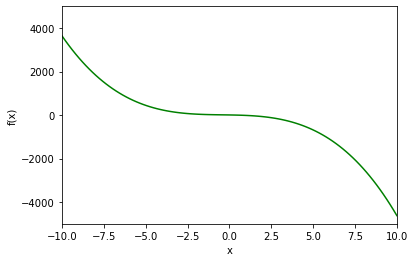

In [430]:
dots = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

plt.plot(dots, f(dots), color='g');

In [431]:
x_datas = []
f_datas = []

for i in range(10):
    x_data = np.random.uniform(-10, 10, 20)
    x_datas.append(x_data)
    f_datas.append([f(i) for i in x_data] + np.random.uniform(-500, 500, 20))

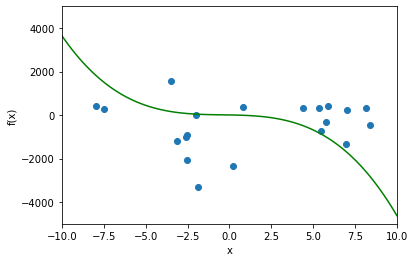

In [432]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

plt.plot(dots, f(dots), color='g')
plt.scatter(x_datas[9], f_datas[1]);

In [433]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

regressors = []
for i in range(10):
    # создадим модель
    regressor = DecisionTreeRegressor(random_state=10, max_depth=10)
    # обучим ее
    regressor.fit(np.reshape(x_datas[i], (-1, 1)), f_datas[i])
    regressors.append(regressor)

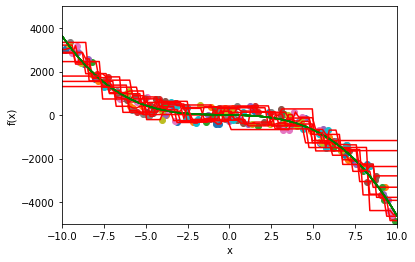

In [434]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

predictions = []
for i in range(10):
    plt.plot(dots, f(dots), color='g')
    plt.scatter(x_datas[i], f_datas[i])
    prediction = regressors[i].predict(np.reshape(dots, (-1, 1)))
    predictions.append(prediction)
    plt.plot(dots, prediction, color='r');
predictions = np.array(predictions)

In [435]:
mean_prediction = np.mean(predictions, axis=0)

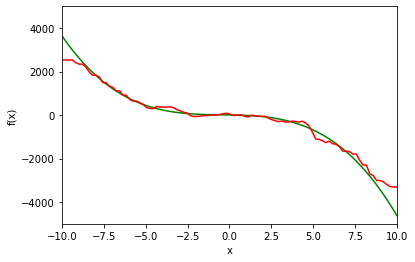

In [436]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

plt.plot(dots, f(dots), color='g')
plt.plot(dots, mean_prediction, color='r');

**Прдемонстрируем высокое смещение (bias) и низкий разброс (variance)**

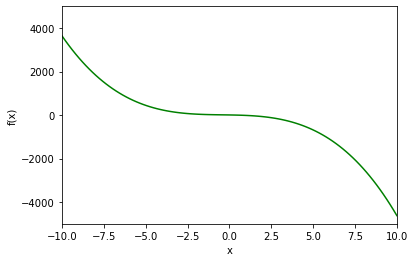

In [437]:
dots = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

plt.plot(dots, f(dots), color='g');

In [438]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

regressors = []
for i in range(10):
    # создадим модель
    regressor = LinearRegression()
    
    # обучим ее
    regressor.fit(np.reshape(x_datas[i], (-1, 1)), f_datas[i])
    regressors.append(regressor)

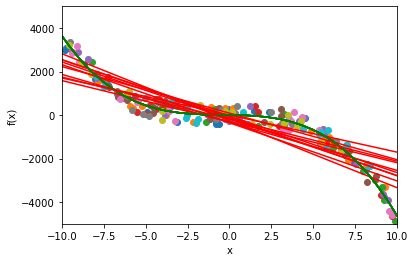

In [439]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

predictions = []
for i in range(10):
    plt.plot(dots, f(dots), color='g')
    plt.scatter(x_datas[i], f_datas[i])
    prediction = regressors[i].predict(np.reshape(dots, (-1, 1)))
    predictions.append(prediction)
    plt.plot(dots, prediction, color='r');
predictions = np.array(predictions)

In [440]:
mean_prediction = np.mean(predictions, axis=0)

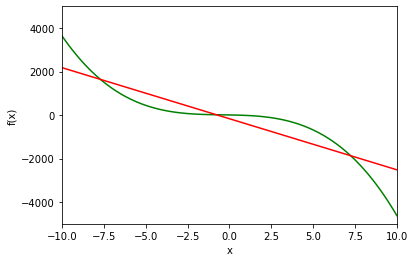

In [441]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

plt.plot(dots, f(dots), color='g')
plt.plot(dots, mean_prediction, color='r');

**Усреднение алгоритмов:**

- Не меняется смещение

- Разброс = $\frac{\text {разброс базового алгоритма}}{N} + \text {корреляция между базовыми алгоритмами}$


Есть два подхода, позволяющих уменьшить корреляцию: 

* _бэггинг_ (обучение базовых алгоритмов на случайной подвыборке),
* _метод случайных подпространств_ (обучение базовых алгоритмов на случайном подмножестве признаков) или их комбинация. 

**Бутстрап**

Случайные леса названы так из-за того, что в процесс построения деревьев, из которых они состоят, внесен элемент случайности для обеспечения уникальности каждого из деревьев. Такая рандомизация заключается в обучении базовых алгоритмов на разных подвыборках обучающей выборки. Один из способов построения случайных подвыборок - _бутстрап (bootstrap)_. Этот метод заключается в получении из выборки длины $l$ нескольких разных выборок той же длины $l$. Для получения бутстрап-выборки из исходной выборки $l$ раз выбирается случайный элемент, причем каждый раз новый элемент выбирается из всей выборки. Таким образом, в полученной в конечном итоге бутстрап-выборке некоторые элементы исходной выборки будут встречаться несколько раз, а некоторые (примерно 37% выборки) будут вовсе отсутствовать, и при повторении $N$ раз мы получим $N$ разных выборок длиной $l$. Например, если у нас есть исходная выборка вида [a, b, c, d, e], возможными бутстрап-выборками могут быть [a, b, a, c, b] или [b, e, e, d, b] и т.д.

<img src="images/bootstrap.png" width=500px>

__Бэггинг__

<img src="images/Bagging.png" width=700px>

__Метод случайных подпространств__

<img src="images/Random_Subspaces.png" width=700px>

## Алгоритм построения случайного леса <a class='anchor' id='alg'>

При построении случайного леса вначале генерируется количество бутстрап-выборок, равное количеству деревьев в алгоритме. Для уменьшения корреляции базовых алгоритмов рандомизируют сам процесс построения каждого дерева: если в стандартном методе построения деревьев мы в каждом узле выбираем $j$-й признак и порог $t$, с которым сравнивается его значение, и потом эти значения оптимизируются с помощью функции ошибки, то в методе случайного леса в каждой вершине $j$-й признак выбирается не из всего пространства признаков, а из его случайного подмножества размера $m$, __которое каждый раз выбирается заново__ (в этом отличие от метода случайных подпространств, где подпространство выбирается единожды и используется для построения всего дерева). 

Есть некоторые практически рекомендации по построению случайных лесов: в задачах классификации рекомендуется брать $m = \sqrt{d}$, где $d$ - общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту, а в задаче регрессии принимать $m = d/3$ и строить дерево, пока в листьях не останется по пять объектов.

Далее построенные деревья объединяются в композицию, и при предсказаниях с его помощью используется усредненный ответ на каждом дереве.

<img src="images/Random_Forest.png" width=600px>


### Out-of-Bag <a class='anchor' id='oob'>
[Пример из sklearn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) по OOB

Вспомним, что каждое дерево $b_{n}$, составляющее случайный лес, строится на основе бутстрапированной выборки $X_{n}$. При этом примерно 37% объектов не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, это и называется _out-of-bag error_. Для каждого объекта $x_{i}$ мы можем найти деревья, которые на нем не обучались, и вычислить ошибку: она рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

10 obj, 5 trees
0 - 1 -> 0, 2 -> 0  -> 0  0
1 - 0 -> 1, 1 -> 0  -> 0  1
2 - 4 -> 0, 5 -> 0  -> 0  0
3 - 1 -> 0
4 - 
5
6
7
8
9

При использовании этого метода оценивания качества исчезает необходимость использовать отложенные выборки и кросс-валидацию при обучении случайных лесов.

## 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [442]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [443]:
# сгенерируем данные, представляющие собой 100 объектов с 2-ю признаками
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

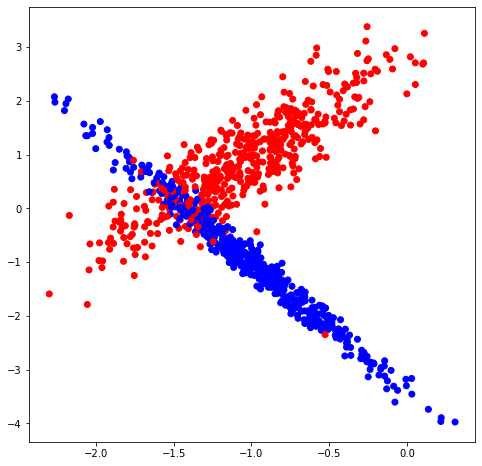

In [444]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [445]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [446]:
get_bootstrap(classification_data, classification_labels, 2)

[(array([[-0.99231065,  1.22996251],
         [-0.23798596, -2.9959103 ],
         [-1.15991652,  0.96765014],
         ...,
         [-0.80425962, -1.40693459],
         [-1.73793907,  0.22284942],
         [-0.61536405,  1.55648581]]),
  array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
         1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
         1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
         0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
         1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
         0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
         1, 

In [447]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [448]:
# get_subsample(16)

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [449]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [450]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [451]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [452]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [453]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [454]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [455]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

NODE (node (node (leaf), (leaf)), (node (node (leaf), node (leaf))))

Теперь добавим функцию формирования случайного леса.

In [456]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [457]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

NODE (node (node (leaf), (leaf)), (node (node (leaf), node (leaf))))

In [458]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [459]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [460]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()],my_forest_1 )).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [461]:
#visualize(train_data, test_data)

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [462]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [463]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [464]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))
    
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [465]:
%%time
n_trees = 1
my_forest = random_forest(train_data, train_labels, n_trees)

CPU times: user 765 ms, sys: 0 ns, total: 765 ms
Wall time: 944 ms


In [466]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)

In [467]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)

In [468]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 93.571
Точность случайного леса из 1 деревьев на тестовой выборке: 88.333


<ipython-input-464-4946ec59015f>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-464-4946ec59015f>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


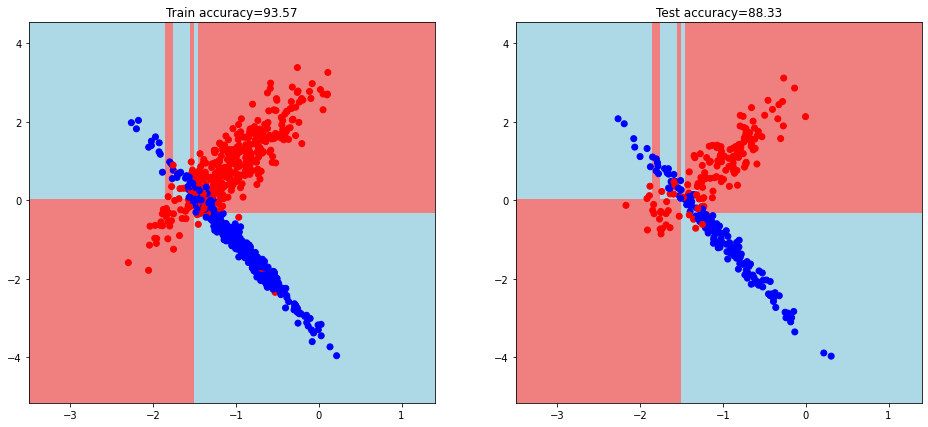

In [469]:
visualize(train_data, test_data)

Построим лес из трех деревьев

In [470]:
%%time
n_trees = 3
my_forest = random_forest(train_data, train_labels, n_trees)

CPU times: user 2.38 s, sys: 8.15 ms, total: 2.39 s
Wall time: 2.6 s


In [471]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)

In [472]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)

In [473]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 95.143
Точность случайного леса из 3 деревьев на тестовой выборке: 88.667


<ipython-input-464-4946ec59015f>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-464-4946ec59015f>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


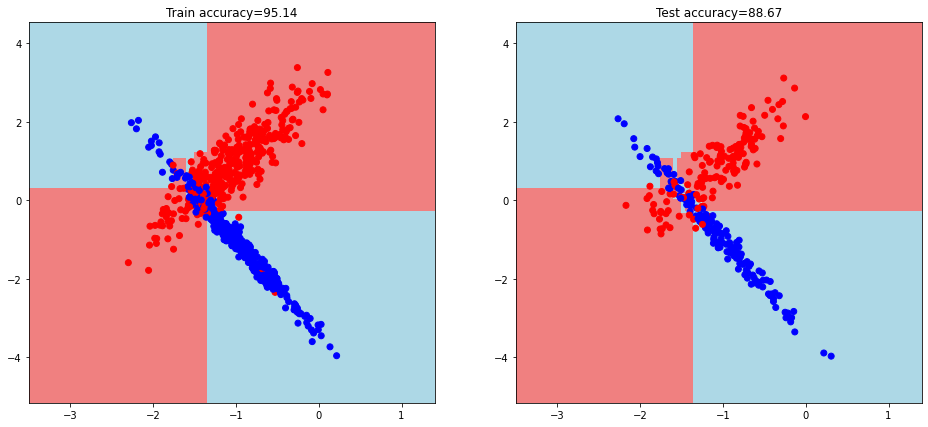

In [474]:
visualize(train_data, test_data)

Построим лес из десяти деревьев

In [475]:
%%time
n_trees = 10
my_forest = random_forest(train_data, train_labels, n_trees)

CPU times: user 8.6 s, sys: 34.5 ms, total: 8.63 s
Wall time: 10.2 s


In [476]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)

In [477]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)

In [478]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 96.429
Точность случайного леса из 10 деревьев на тестовой выборке: 90.667


<ipython-input-464-4946ec59015f>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-464-4946ec59015f>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


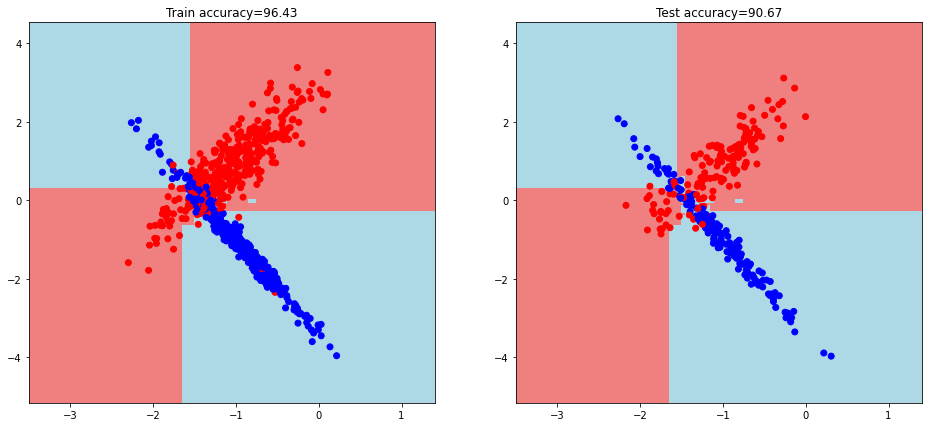

In [479]:
visualize(train_data, test_data)

Построим лес из пятидесяти деревьев

In [480]:
%%time
n_trees = 50
my_forest = random_forest(train_data, train_labels, n_trees)

CPU times: user 43.3 s, sys: 63.7 ms, total: 43.3 s
Wall time: 46.1 s


In [481]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)

In [482]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)

In [483]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 98.000
Точность случайного леса из 50 деревьев на тестовой выборке: 91.333


<ipython-input-464-4946ec59015f>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-464-4946ec59015f>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


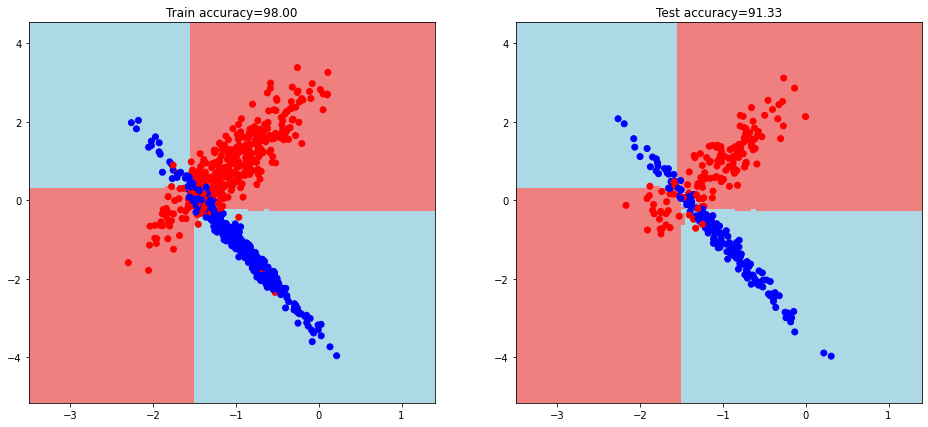

In [484]:
visualize(train_data, test_data)

Как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает при увеличении числа деревьев в нем. При этом по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес не переобучается. Это одна из основных особенностей случайного леса - он редко переобучается при увеличении числа базовых алгоритмов, а ошибка выходит на асимптоту.

## Домашнее задание<a class='anchor' id='hw'>

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
сделано выше для 1000 объектов
2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

### 1) сложность гиперплоскости увеличивается

### 2) при увеличении числа деревьев - точность растет на тестовой выборке


3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.
4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

Проект: 
1. https://www.kaggle.com/c/gb-tutors-expected-math-exam-results регрессия
1. https://www.kaggle.com/c/gb-choose-tutors классификация

## Дополнительные материалы

1. [Смещение и разброс](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)
2. [Бэггинг с точки зрения статистики](https://habr.com/ru/company/ods/blog/324402/#begging)
3. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
4. [Случайный лес (Random Forest)](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/)
5. [Реализация и разбор алгоритма «случайный лес» на Python](https://tproger.ru/translations/python-random-forest-implementation/)
6. [Прикладные задачи анализа данных. Случайные леса](http://www.machinelearning.ru/wiki/images/c/cc/PZAD2016_09_rf.pdf)
7. Андреас Мюллер, Сара Гвидо, Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными (2016)

**Материалы по OOB:**
1. [Статья с курса по ML от ODS](https://habr.com/ru/company/ods/blog/324402/#out-of-bag-error)
2. [Тоже хорошее объяснение](https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710)
3. [Пример из документации sklearn'a](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)
4. [И очень хорошее видео про случайный лес и в частности OOB](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ)

## Summary

__Случайный лес__

* Один из сильнейших “классических" алгоритмов машинного обучения
* Не требователен к обучающей выборке (не требуется нормализация, очистка от шума, ...) 
* Легко параллелится, так как базовые модели обучаются независимо друг от друга
* Слабо подвержен переобучению 
* Дает оценку важности признаков (feature importance)
* Не требует дополнительной валидационной выборки (за счет OOB-score)

### Определения
*Композиции*

**Ансамбли** — это методы, сочетающие в себе несколько алгоритмов машинного обучения для получения более мощной модели.

**Бутстрап (bootstrap)** — метод сэмплирования подвыборки. Заключается в получении из выборки длины  𝑙  нескольких разных выборок той же длины  𝑙.

**Бэггинг** — обучение базовых алгоритмов на случайной подвыборке.

**Метод случайных подпространств** — обучение базовых алгоритмов на случайном подмножестве признаков или их комбинация. 

*Разложение ошибки*

**Смещение (bias)** — отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма.

**Разброс или дисперсии (variance)** — разброс ответов обученных алгоритмов отнисительно среднего ответа.

**Шум** — ошибка идеального алгоритма, характеристика входных данных.

